# Imports

In [1]:
## for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "symmetry_detection")
import trimesh

# from utils.show_mesh import *
# from utils.visualization_tool import *

from utils.symmetry_vect import *
from utils.curvature import *
from utils.HKS import *

import igl
import trimesh
import meshplot as mp
from lovely_numpy import lo
import matplotlib.pyplot as plt

In [2]:
# !ls ManifoldPlus/results/
# !ls symmetry_detection/meshes/
!ls symmetry_detection/meshes/tower_model

textures  tower.mtl  tower.obj


In [3]:
# meshes = trimesh.load('meshes/table_and_chair_2_model/table_and_chair_2.obj')
# meshes = trimesh.load('symmetry_detection/meshes/jug.obj')
# meshes = trimesh.load('symmetry_detection/meshes/tower_model/tower.obj') # bad
# meshes = trimesh.load('ManifoldPlus/data/chair.off')
meshes = trimesh.load("symmetry_detection/meshes/cylinder.obj")

# meshes = trimesh.creation.capsule(radius=0.25, height=0.75)
# meshes = trimesh.creation.cylinder(radius=0.25, height=0.75)
# v, f = trimesh.remesh.subdivide(meshes.vertices, meshes.faces)
# meshes = trimesh.Trimesh(vertices=v, faces=f)
# meshes = trimesh.creation.box()

print(meshes)
def as_mesh(scene_or_mesh):
    """
    Convert a possible scene to a mesh.

    If conversion occurs, the returned mesh has only vertex and face data.
    """
    if isinstance(scene_or_mesh, trimesh.Scene):
        if len(scene_or_mesh.geometry) == 0:
            mesh = None  # empty scene
        else:
            # we lose texture information here
            mesh = trimesh.util.concatenate(
                tuple(trimesh.Trimesh(vertices=g.vertices, faces=g.faces)
                    for g in scene_or_mesh.geometry.values()))
    else:
        assert(isinstance(scene_or_mesh, trimesh.Trimesh))
        mesh = scene_or_mesh
    return mesh

mesh = as_mesh(meshes)
print(mesh)

mesh.vertices /= np.linalg.norm(mesh.vertices, axis=-1).max()
mesh.vertices -= mesh.center_mass
mesh.visual.vertex_colors = [255,255,255,255]
print(mesh.vertices.max(), mesh.vertices.min())
mesh.show()


<trimesh.Trimesh(vertices.shape=(16454, 3), faces.shape=(32904, 3))>
<trimesh.Trimesh(vertices.shape=(16454, 3), faces.shape=(32904, 3))>
0.8320447094779133 -0.8320549966291602


# Curvatures

In [4]:
v, f = mesh.vertices, mesh.faces
gaussian_curvatures = igl.gaussian_curvature(mesh.vertices, mesh.faces)
gaussian_curvatures.shape # One per vertex

(16454,)

In [5]:
v1, v2, k1, k2 = igl.principal_curvature(mesh.vertices, mesh.faces)
print("K1", lo(k1))
print("V1all :", lo(v1))
print("V1norm:", lo(np.linalg.norm(v1, axis=-1)))
curvd1, curvd2 = v1, v2

K1 array[16454] 0.1Mb x∈[-1.923, 6.556] μ=0.142 σ=0.700
V1all : array[16454, 3] n=49362 (0.4Mb) x∈[-1.000, 1.000] μ=0.001 σ=0.522
V1norm: array[16454] 0.1Mb x∈[0., 1.000] μ=0.818 σ=0.386


In [6]:
h2 = 0.5 * (k1 + k2)
# p = mp.plot(v, f, h2, shading={"wireframe": False}, return_plot=True)
p = mp.plot(v, f, gaussian_curvatures, 
            shading={"wireframe": False}, return_plot=True)
avg = igl.avg_edge_length(v, f) / 2.0
mult = 10
p.add_lines(v + v1 * avg * k1[:, None] / k1.max() *mult, 
            v - v1 * avg * k1[:, None] / k1.max() *mult, 
            shading={"line_color": "red"})
p.add_lines(v + v2 * avg * k2[:, None] / k2.max() *mult, 
            v - v2 * avg * k2[:, None] / k2.max() *mult, shading={"line_color": "yellow"})

/home/grendelyang/anaconda3/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(
/home/grendelyang/anaconda3/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1920928…

2

array[16454] 0.1Mb x∈[0., 6.505] μ=0.958 σ=0.984


/tmp/ipykernel_23033/3390225044.py:2: RuntimeWarning: invalid value encountered in log
  return np.where(np.abs(h2) < thr, h2, thr - eps + np.log(np.abs(h2) - thr + eps))


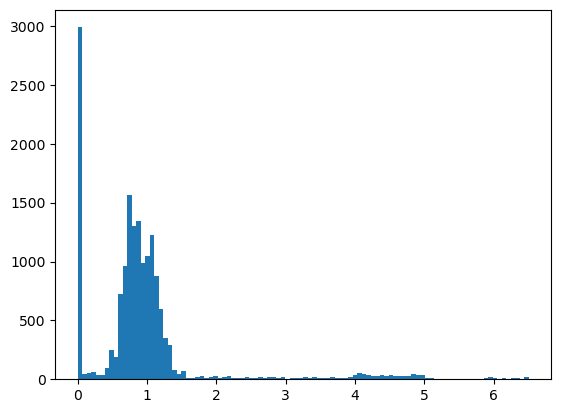

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1920928…

In [7]:
def better_display(data, thr=10, eps=1):
    return np.where(np.abs(h2) < thr, h2, thr - eps + np.log(np.abs(h2) - thr + eps))
dh2 = better_display(h2, thr=5, eps=1)
print(lo(dh2))
plt.hist(dh2.flatten(), bins=100)
plt.show()
mp.plot(v, f, dh2, shading={"wireframe": False})

# Validity

In [8]:
# Compute validity
eps = 1e-6
min_abs = np.minimum(np.abs(k1), np.abs(k2))
max_abs = np.maximum(np.abs(k1), np.abs(k2))
valid = np.logical_not(
    np.logical_or(
        np.abs(min_abs / (max_abs + eps)) > 0.9,
        max_abs < 1
    ))
valid.sum(), valid.astype(np.float32).mean() * 100

(13156, 79.9562394618988)

In [9]:
# Yellow is Valid!
mp.plot(v, f, valid, shading={"wireframe": False})

# test = np.zeros_like(valid)
# test[:1000] = 1
# mp.plot(v, f, test, shading={"wireframe": False})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1920928…

# Subsample

In [10]:
n_samples = 200
idxs = np.arange(v.shape[0])[valid]
valid_points = np.array(mesh.vertices)[idxs]
print("Valid points", lo(valid_points))
ridxs1 = np.random.choice(idxs.shape[0], n_samples) 
ridxs2 = np.random.choice(idxs.shape[0], n_samples) 
sample_idxs1 = idxs[ridxs1]
sample_idxs2 = idxs[ridxs2]
lo(sample_idxs1), lo(sample_idxs2)

Valid points array[13156, 3] n=39468 (0.3Mb) x∈[-0.832, 0.832] μ=0.027 σ=0.426


(array[200] i64 1.6Kb x∈[54, 16416] μ=8.308e+03 σ=4.957e+03,
 array[200] i64 1.6Kb x∈[9, 16406] μ=8.350e+03 σ=4.826e+03)

In [11]:
sample = mesh.vertices[sample_idxs1]
subsample = mesh.vertices[sample_idxs2]
lo(sample), lo(subsample)

(TrackedArray[200, 3] n=600 (4.7Kb) x∈[-0.832, 0.832] μ=0.023 σ=0.432,
 TrackedArray[200, 3] n=600 (4.7Kb) x∈[-0.832, 0.832] μ=0.015 σ=0.432)

In [12]:
mp.plot(sample, shading={"point_size": 0.1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000138…

In [13]:
mp.plot(subsample, shading={"point_size": 0.1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000166…

# Signatures

Signature array[16454] 0.1Mb x∈[-5.218e+04, 1.012e+05] μ=-15.952 σ=1.284e+03
array[16454] 0.1Mb x∈[0., 2.788] μ=0.515 σ=0.461


/tmp/ipykernel_23033/3390225044.py:2: RuntimeWarning: divide by zero encountered in log
  return np.where(np.abs(h2) < thr, h2, thr - eps + np.log(np.abs(h2) - thr + eps))


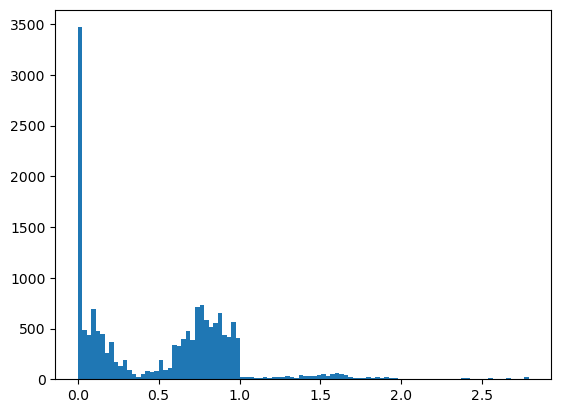

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1920928…

In [14]:
eps = 1e-6
signatures = np.maximum(k1, k2) / (np.minimum(k1, k2) + eps)
print("Signature", lo(signatures))
dsig = better_display(signatures, thr=1)
print(lo(dsig))
plt.hist(dsig.flatten(), bins=100)
plt.show()
mp.plot(v, f, dsig, shading={"wireframe": False})

(16454,) (16454,)


Text(0, 0.5, 'k2')

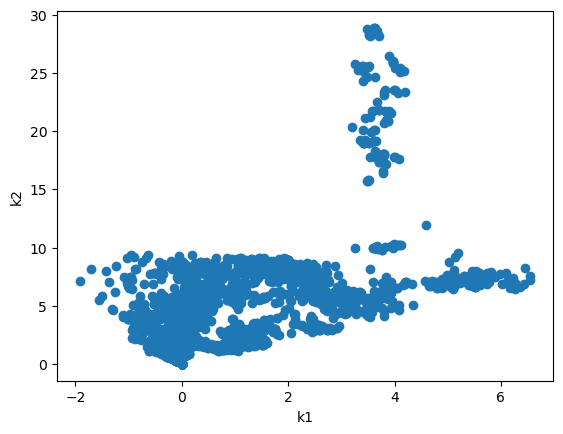

In [15]:
print(k1.shape, k2.shape)
plt.scatter(k1, k2)
plt.xlabel('k1')
plt.ylabel('k2')

In [16]:
idx = np.where(k2 > 15)


# Point Pairs Similarities

In [17]:
from numpy import linalg as LA

def symmetry_test(k1, k2):
    # PC rearranged
    n = k1.shape[0]
    # pc = np.stack([np.maximum(k1, k2), np.minimum(k1, k2)], axis=-1).reshape(-1, 2)
    pc = np.stack([k1, k2], axis=-1).reshape(-1, 2)
    diff = pc[None, ...] - pc[:, None, :] # (n, n, 2)
    return LA.norm(diff, axis=-1).reshape(n, n)
sim = symmetry_test(k1, k2)
print(sim.shape)

(16454, 16454)


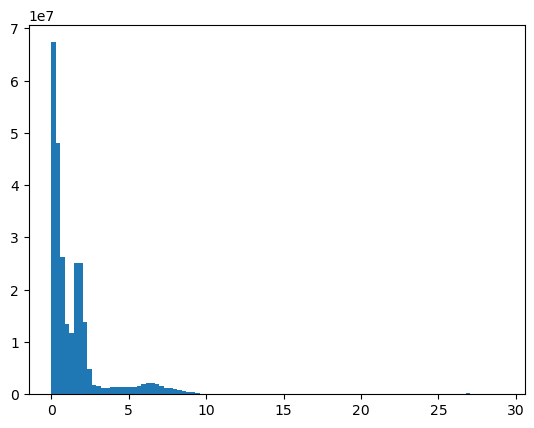

In [18]:
plt.hist(sim.reshape(-1), bins=100)
# plt.xscale("log")
plt.show()

array[16454] 0.1Mb x∈[0., 27.355] μ=1.043 σ=2.163


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1920928…

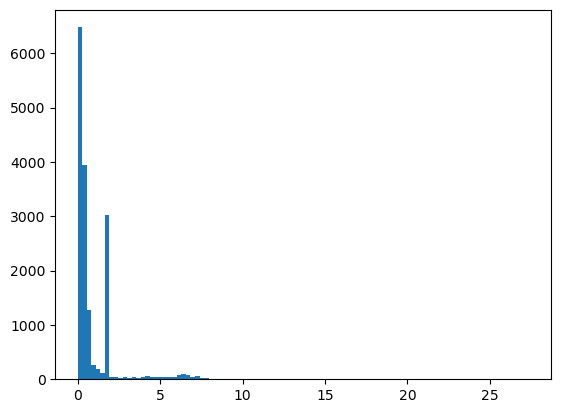

In [19]:
vidx = 1000
sim_to_vertex = sim[vidx]
print(lo(sim_to_vertex))
plt.hist(sim_to_vertex.flatten(), bins=100)
mp.plot(v, f, sim_to_vertex, shading={"wireframe": False})

# Symmetry Tests

In [20]:
ridxs1.shape, ridxs2.shape

((200,), (200,))

## Test Symmetry Function

In [21]:

def visualize_curvatures_and_normals(mesh, v, normals, d1, d2):
    # Create a meshplot plot object
    p = mp.plot(mesh.vertices)
    
    # Add normals to the plot
    p.add_lines(v, v + normals * 0.1, shading={"line_color": "red"})
    
    # Add principal curvature directions to the plot
    p.add_lines(v, v + d1 * 0.1, shading={"line_color": "green"})
    p.add_lines(v, v + d2 * 0.1, shading={"line_color": "blue"})

    return p


In [22]:
pc1, pc2, k1, k2 = igl.principal_curvature(mesh.vertices, mesh.faces)
idxs = np.random.choice(mesh.vertices.shape[0], 1)
k1[idxs], k2[idxs]

(array([-0.10850474]), array([1.30773624]))

In [28]:
v1 = np.array([0., 0., 0.])
v2 = np.array([0., 0., 1.])
n1 = np.array([0., 0., 1.])
n2 = np.array([0., 0., 1.])
pcd1 = np.array([[0., 1., 0.], [1., 0., 0.]]) 
pcd2 = np.array([[0., 1., 0.], [1., 0., 0.]]) 
sym = get_symmetry_vect_np(v1, n1, pcd1, v2, n2, pcd2)
sym

ValueError: Found zero norm quaternions in `quat`.

In [24]:
# Random sample two pair of points
idxs = np.random.choice(mesh.vertices.shape[0], 2)
normals = igl.per_vertex_normals(mesh.vertices, mesh.faces)[idxs]
pc1, pc2, k1, k2 = igl.principal_curvature(mesh.vertices, mesh.faces)
pc1, pc2, k1, k2 =pc1[idxs], pc2[idxs], k1[idxs], k2[idxs]

print(normals.shape, pc1.shape, pc2.shape, k1.shape, k2.shape)
pcd1 = np.stack([pc1[0], pc2[1]], axis=0)
pcd2 = np.stack([pc1[0], pc2[1]], axis=0)
print(pcd1.shape, pcd2.shape)
print(pc1.shape, pc2.shape)
vertex = mesh.vertices[idxs]
v1, v2 = vertex[0], vertex[1]
n1, n2 = normals[0], normals[1]
sym = get_symmetry_vect_np(v1, n1, pcd1, v2, n2, pcd2)
print(sym)
R, T, S = sym[:3], sym[3:6], sym[-1]
print(R / 2 / np.pi * 360., T, S)


visualize_curvatures_and_normals(
    mesh,
    np.stack([v1, v2]), # v:   (n, 3)
    np.stack([n1, n2]), # sfn: (n, 3)
    np.stack([pcd1[0] * k1[0], pcd2[0] * k2[0]], axis=0), # d1:  (n, 3)
    np.stack([pcd1[
              1] * k1[1], pcd2[1] * k2[1]], axis=0), # d2:  (n, 3)
)

(2, 3) (2, 3) (2, 3) (2,) (2,)
(2, 3) (2, 3)
(2, 3) (2, 3)
[-9.11824836e-03 -7.05741737e-03  2.74976939e+00  2.50934388e-03
  2.47011808e-03  8.65703684e-01  1.00000000e+00]
[ -0.52243715  -0.40436023 157.55018093] [0.00250934 0.00247012 0.86570368] 1.0


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1920928…

In [26]:
from scipy.spatial.transform import Rotation

def homo(v):
    return np.concatenate([v.flatten(), np.ones(1)]).reshape(-1)

def apply_sym(sym, v, n, pcd):
    R, T, S = sym[:3], sym[3:6], sym[-1]
    mat = np.eye(4)
    mat[:3, :3] = Rotation.from_euler('xyz', R).as_matrix()
    mat[3:, :3] = T
    mat[3, 3] = S

    def f(x):
        x_out = np.matmul(mat, homo(x))
        x_out = x_out[:3] / x_out[3]
        return x_out
    v_out = f(v)
    n_out = f(v + n) - v_out
    pcd1_out = f(v + pcd[0]) - v_out
    pcd2_out = f(v + pcd[1]) - v_out
    pcd_out = np.stack([pcd1_out, pcd2_out], axis=0)
    return v_out, n_out, pcd_out


v2_, n2_, pcd2_ = apply_sym(sym, v1, n1, pcd1)
print(v2_, v2)
visualize_curvatures_and_normals(
    mesh,
    np.stack([v1, v2]), # v:   (n, 3)
    np.stack([n1, n2]), # sfn: (n, 3)
    np.stack([pcd1[0], 
              pcd2[0],
             ], axis=0), # d1:  (n, 3)
    np.stack([pcd1[1], 
              pcd2[1],
             ], axis=0), # d2:  (n, 3)
)

visualize_curvatures_and_normals(
    mesh,
    np.stack([v1, v2, v2_]), # v:   (n, 3)
    np.stack([n1, n2, n2_]), # sfn: (n, 3)
    np.stack([pcd1[0], 
              pcd2[0],
              pcd2_[0]
             ], axis=0), # d1:  (n, 3)
    np.stack([pcd1[1], 
              pcd2[1],
              pcd2_[1]
             ], axis=0), # d2:  (n, 3)
)

# def forward(x):
#     return Rmat 

[ 0.56573657 -0.25640793 -0.14713397] [ 0.50542494 -0.22546556  0.73490788]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1920928…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1920928…

In [ ]:
v1_, n1_, pcd1_ = apply_sym(sym, v2, n2, pcd2)
print(v1_, v1)

visualize_curvatures_and_normals(
    mesh,
    np.stack([v1, v2, v1_]), # v:   (n, 3)
    np.stack([n1, n2, n1_]), # sfn: (n, 3)
    np.stack([pcd1[0] * k1[0], 
              pcd2[0] * k2[0],
              pcd1_[0] * k1[0]
             ], axis=0), # d1:  (n, 3)
    np.stack([pcd1[1] * k1[1], 
              pcd2[1] * k2[1],
              pcd1_[1] * k1[1]
             ], axis=0), # d2:  (n, 3)
)

# Compute the Acual One

In [ ]:
from utils.symmetry_vect import get_symmetry_vect_np
pc = np.stack([np.maximum(k1, k2), np.minimum(k1, k2)], axis=-1).reshape(-1, 2)
normals = igl.per_vertex_normals(mesh.vertices, mesh.faces)

thr_lo, thr_hi = 0., 0.5
# thr_lo, thr_hi = 0.5, 5
# thr_lo, thr_hi = 5, 10.

pairs = []
symms = []
logTs = []
for i in ridxs1:
    for j in ridxs2:
        if sim[i, j] <= thr_hi and sim[i, j] >= thr_lo and i != j:
            pairs.append((i, j))
            v1, v2 = mesh.vertices[i], mesh.vertices[j]
            n1, n2 = normals[i], normals[j]
            # curvd1, curvd2 = v1, v2
            pcd1 = np.stack([curvd1[i], curvd2[i] ], axis=0)
            pcd2 = np.stack([curvd1[j], curvd2[j] ], axis=0)
            sym = get_symmetry_vect_np(v1, n1, pcd1, v2, n2, pcd2)
            symms.append(sym)
            logTs.append(log_map(sym))

symms = np.array(symms)
pairs = np.array(pairs)
logTs = np.array(logTs)
pairs.shape, len(symms), len(logTs)

In [ ]:
# Visualize potential symmetry pairs
# p = mp.plot(v, f, gaussian_curvatures, 
            # shading={"wireframe": False}, return_plot=True)
p = mp.plot(v,
            shading={"wireframe": False, "point_size": 0.01}, 
            return_plot=True)

for idx in np.random.choice(pairs.shape[0], size=1000):
    i, j = pairs[idx]
    p.add_lines(v[i], v[j], shading={"line_color": "blue"})

# LogT

In [ ]:
Lie_alg = logTs
symms.shape, logTs.shape, Lie_alg.shape, lo(Lie_alg)

In [ ]:
logTs.shape

# Visualize Symmetry

In [ ]:
from sklearn.manifold import TSNE

X = Lie_alg
X_embedded = TSNE(
    n_components=2, learning_rate='auto', init='random', perplexity=1).fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

# Symmetry Similarity Computing

In [ ]:
# NOTE this is huge - need to be careful on this

In [ ]:
from utils.symmetry_vect import adjoint_invar_norm_vec
print(lo(logTs))
print(lo(logTs[None, ...]))
print(lo(logTs[:, None, ...]))
log_map_minus = (logTs[None, ...] - logTs[:, None, :]).reshape(-1, logTs.shape[-1])

print(lo(log_map_minus))
adjoint_invar_norm_minus = adjoint_invar_norm_vec(log_map_minus)
print(lo(adjoint_invar_norm_minus))

log_map_add   = (logTs[None, ...] + logTs[:, None, :]).reshape(-1, logTs.shape[-1])
adjoint_invar_norm_add   = adjoint_invar_norm_vec(log_map_add)
print(lo(adjoint_invar_norm_add))

sym_dist_out  = np.minimum(
    adjoint_invar_norm_minus, adjoint_invar_norm_add
).reshape(logTs.shape[0], logTs.shape[0])

dissim = sym_dist_out

In [ ]:
dissim.shape

In [ ]:
dissim = dissim[~np.isnan(dissim)]
dissim = dissim.reshape(int(np.sqrt(dissim.shape[0])), -1)
# visualize_dist_3D(dissim)
lo(dissim)

In [ ]:
plt.hist(dissim.flatten(), bins=100)
plt.show()

# Symmetry through MeanShift Clustering

In [ ]:
from sklearn.cluster import MeanShift

clustering = MeanShift().fit(symms)
clustering.cluster_centers_

In [ ]:
print(lo(clustering.cluster_centers_))
print(lo(clustering.labels_))

In [ ]:
label = 0
symms_labeled = symms[np.where(clustering.labels_ == label)]
pairs_labeled = pairs[np.where(clustering.labels_ == label)]
print(pairs_labeled.shape, pairs_labeled.max(), pairs_labeled.min(), pairs_labeled.dtype)

p = mp.plot(
    mesh.vertices.astype(np.float32), 
    return_plot=True, 
    shading={"point_size": 0.05})
p.add_edges(
    mesh.vertices.astype(np.float32), 
    pairs_labeled,
    shading={"line_color": "blue"})